# Continuous Time Sphere Model

We model the example of short-lived temperature sensors on the Earth in continuous time, using a combination of a queueing model and point process. Throughout the setup of the model, fix a time $T;$ for each time $t \in [0,T]$ the set of sensors $S_t$ at time $t$ is a set of locations on $\mathbb{S}^2,$ where $|S_t|$ is a random variable, and $S_t(i),$ the location of the $i$th sensor is uniformly sampled from the uniform measure on the sphere.

Perhaps the easiest way to set up the model is via a (FIFO) queueing model, or birth-death process representing the sensors:

- We start with $L_0$ number of sensors, each sampled uniformly from the sphere. 
- Sensors are added to the queue every so often, again sampled uniformly from the sphere. 
- Independently of the creation of new sensors, sensors break down at a perhaps different rate, and leave the queue.

We can model the time between consecutive joining/ exiting of the queue by exponential distributions.


## Queueing Model Implementation
Consider a queueing model whose initial length is $L_0,$ the number of initial sensors we begin with. We assume that the queue processes sensors (physically: sensors break down) in a random time $\sim \text{Exp}(\lambda_1),$ and sensors join the queue with interarrival times distributed according to $\text{Exp}(\lambda_2),$ which are independent of the times it takes for the queue to process the input.

We can simulate this queue in the following way. For a given fixed time $t \in [0,T],$ by the memoryless property of exponential distributions, the time until a sensor leaves the queue is still $X_1 \sim \text{Exp}(\lambda_1)$ and the interarrival time is still distributed according to $X_2 \text{Exp}(\lambda_2).$ Now, the time until one of these two actions occurs is a random variable $Z = \min(X_1,X_2) \sim \text{Exp}(\lambda_1+\lambda_2)$ (which can be checked). Now the probability that a sensor joins the queue first is $\mathbb{P}(X_1 > X_2) = \frac{\lambda_1}{\lambda_1 + \lambda_2},$ and one minus that for the probability that a sensor breaks and leaves the queue. We can then model the process by waiting $\text{Exp}(\lambda_1+\lambda_2)$ amount of time, and with probability $\frac{\lambda_1}{\lambda_1 + \lambda_2},$ adding a new sensor to the queue, or otherwise removing the oldest sensor from the queue.

## Dynamic Network Analysis
The continuous time model allows us to subsample as finely as we want. We keep track of the birth/death of the sensors in an interval tree; for any $t \in [0,T]$ we query the interval tree for the set of points that are present on the sphere at that time, and then create a dynamic network via the delaunay construction, assigining node values via some observation function representing temperature, or another desired quantity, and the edge weights by distance on the sphere.

# Run the Dynamic Network Analysis

In [1]:
from __future__ import division
import numpy as np
import sys
import os
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.spatial.distance import squareform
import importlib
import scipy.spatial as sp

## Load in sphere code
sys.path.append('../data/simple_egs')
import SphereExample as sphere
import ContinuousTimeSensorModel as ctsm
importlib.reload(ctsm)
importlib.reload(sphere)

## Load in d.n. analysis code
sys.path.append('../shared_scripts/')
import graph_fns as gf
import persistence_fns as pf
import sliding_window_fns as sw
from ripser import ripser
from persim import plot_diagrams
from sklearn import manifold

In [ ]:
## Setup Sensor Lifetimes
T = 15 # Period 

obsfn = lambda t, p: sphere.periodic_northsouth_modulated(t,p,T)
edge_wtsfn = lambda hull_obj: sphere.get_edge_wts(hull_obj, alpha = 1.0)

lambda1 = 50
lambda2 = lambda1

sensor_lifetimes = ctsm.get_sensor_lifetimes(2.5*T, lambda1, lambda2)

In [ ]:
## Create the Dynamic Network
dynamic_network_samples = 200
ts = np.linspace(0,2*T,dynamic_network_samples)

(node_wts,edge_wts, allpoints) = ctsm.sample_dynamic_network(sensor_lifetimes, ts, obsfn = obsfn,
                                    edge_wtsfn = edge_wtsfn)

In [13]:
## Apply the analysis

# apply phi functions, and scale the weights
phi_node_wts, phi_edge_wts = gf.weight_fn(node_wts, edge_wts, lamda=1, phi=sphere.linear_phi_fn)

# construct the filtrations / simplicial complexes according to our construction
filtration_matrix = list(map(lambda n, e: pf.get_filtration(n, e), phi_node_wts, phi_edge_wts))

# summarize these filtrations using H_0 barcodes
barcodes = list(map(pf.get_rips_complex, filtration_matrix))

In [96]:
## Video of the example

xs = []
for nw in phi_node_wts:
    xs += nw.tolist()
xs = np.array(xs)
nmin = np.min(xs)
nmax = np.max(xs)
plt.figure(figsize=(18, 6))
for i, (pts, nw, dgm) in enumerate(zip(allpoints, phi_node_wts, barcodes)):
    plt.clf()
    ax = plt.gcf().add_subplot(121, projection='3d')
    pts = np.concatenate((pts, np.zeros((2, 3))), 0)
    nw = np.concatenate((nw, np.array([nmin, nmax])))
    p = ax.scatter(pts[:, 0], pts[:, 1], pts[:, 2], c=nw, s=100, cmap=plt.get_cmap("magma"))
    plt.colorbar(p)
    hull = sp.ConvexHull(pts)
    for simplex in hull.simplices:
        ax.plot(pts[simplex, 0], pts[simplex, 1], pts[simplex, 2], 'k-')
    plt.title("Timestep %i"%i)
    plt.subplot(122)
    plot_dgms(dgm, labels=['H0'])
    plt.xlim([4, 12])
    plt.ylim([4, 12])
    plt.title("%i Nodes, %i Dots"%(nw.shape[0]-2, dgm.shape[0]))
    plt.savefig("Images/SphHarmCtsEx/%i.png"%i, bbox_inches='tight')

/Users/sianamuljadi/anaconda/lib/python3.6/site-packages/ripser-0.3.1-py3.6-macosx-10.7-x86_64.egg/ripser/ripser.py:341: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=10.0, right=10.0
  ax.set_xlim([x_down, x_up])
/Users/sianamuljadi/anaconda/lib/python3.6/site-packages/ripser-0.3.1-py3.6-macosx-10.7-x86_64.egg/ripser/ripser.py:342: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=10.0, top=10.0
  ax.set_ylim([y_down, y_up])
/Users/sianamuljadi/anaconda/lib/python3.6/site-packages/ripser-0.3.1-py3.6-macosx-10.7-x86_64.egg/ripser/ripser.py:341: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=10.0, right=10.0
  ax.set_xlim([x_down, x_up])
/Users/sianamuljadi/anaconda/lib/python3.6/site-packages/ripser-0.3.1-py3.6-macosx-10.7-x86_64.egg/ripser/ripser.py:342: UserWarning: At

# Vary Parameters

In [17]:
## Create the dynamic network
T = 10 # Period 

obsfn = lambda t, p: sphere.periodic_northsouth_modulated(t,p,T)
edge_wtsfn = lambda hull_obj: sphere.get_edge_wts(hull_obj, alpha = 1.0) #what is alpha?

lambda1 = 50
lambda2 = lambda1

sensor_lifetimes = ctsm.get_sensor_lifetimes(5*T, lambda1, lambda2)


## Vary Window Length and Dimension
window_length_test_values = np.linspace(0,2*T,19)[1:]
dim_test_values = range(4,20)

mpers_results = np.zeros((len(window_length_test_values),len(dim_test_values)))
top_diff_results = np.zeros((len(window_length_test_values),len(dim_test_values)))

for i,wl in enumerate(window_length_test_values):
    for j,d in enumerate(dim_test_values):
        print(wl,d)

        # resample dynamic network 
        tau = wl/d
        ts = np.arange(0,4*T,tau) 
        
        (node_wts,edge_wts, allpoints) = ctsm.sample_dynamic_network(sensor_lifetimes, ts, obsfn = obsfn,
                                    edge_wtsfn = edge_wtsfn)
        
        PDs = sphere.apply_pipeline(node_wts,edge_wts, d = d, tau = tau, lamda=1, phi=sphere.linear_phi_fn) # get the PDs
        res = (sphere.get_maximum_persistence(PDs)[1],sphere.get_top_diff_persistence(PDs)[1], sphere.get_num_features(PDs)[1])
        print(res)

        mpers_results[i,j] = res[0]
        top_diff_results[i,j] = res[1]

1.11111111111 4
(0.65168499946594238, 0.12511444091796875, 61)
1.11111111111 5
(0.66723895072937012, 0.089043378829956055, 81)
1.11111111111 6
(0.79808855056762695, 0.080408334732055664, 99)
1.11111111111 7
(1.0111181735992432, 0.24851155281066895, 113)
1.11111111111 8
(0.96992945671081543, 0.19436526298522949, 127)
1.11111111111 9
(1.0387334823608398, 0.1576075553894043, 145)
1.11111111111 10
(1.2829585075378418, 0.36514019966125488, 153)
1.11111111111 11
(1.1549654006958008, 0.27648305892944336, 175)
1.11111111111 12
(1.6499936580657959, 0.60654449462890625, 180)
1.11111111111 13
(1.5224330425262451, 0.25348877906799316, 179)
1.11111111111 14
(1.753277063369751, 0.54421043395996094, 213)
1.11111111111 15
(1.7081396579742432, 0.6843268871307373, 222)
1.11111111111 16
(1.6464037895202637, 0.36028623580932617, 237)
1.11111111111 17
(1.8531863689422607, 0.66886162757873535, 241)
1.11111111111 18
(1.8963313102722168, 0.48339486122131348, 243)
1.11111111111 19
(2.0573220252990723, 0.710978

(2.1321125030517578, 1.8028512001037598, 6)
10.0 11
(2.7020244598388672, 2.0920600891113281, 7)
10.0 12
(2.8902328014373779, 2.3059329986572266, 9)
10.0 13
(3.1898567676544189, 2.5609221458435059, 9)
10.0 14
(3.4210634231567383, 2.6883766651153564, 20)
10.0 15
(3.6785397529602051, 3.039097785949707, 21)
10.0 16
(3.6901979446411133, 3.1476154327392578, 22)
10.0 17
(3.9878947734832764, 3.565354585647583, 25)
10.0 18
(3.9828495979309082, 3.4750070571899414, 29)
10.0 19
(4.2684836387634277, 3.7656331062316895, 32)
11.1111111111 4
(0.86215353012084961, 0.86215353012084961, 1)
11.1111111111 5
(1.0412769317626953, 1.0410699844360352, 2)
11.1111111111 6
(1.2290580272674561, 1.1119215488433838, 2)
11.1111111111 7
(1.3278553485870361, 1.3278553485870361, 1)
11.1111111111 8
(1.4456937313079834, 1.3406209945678711, 2)
11.1111111111 9
(1.4916849136352539, 1.3424973487854004, 6)
11.1111111111 10
(1.9493165016174316, 1.5480704307556152, 6)
11.1111111111 11
(2.5052804946899414, 1.7645125389099121, 6)


(3.027245044708252, 2.3214621543884277, 7)
20.0 4
(0, 0, 0)
20.0 5
(0.080127239227294922, 0.080127239227294922, 1)
20.0 6
(0, 0, 0)
20.0 7
(0.69820261001586914, 0.69820261001586914, 1)
20.0 8
(0.18928718566894531, 0.18928718566894531, 1)
20.0 9
(1.3073983192443848, 1.3073983192443848, 1)
20.0 10
(0.44124174118041992, 0.44124174118041992, 1)
20.0 11
(1.747321605682373, 1.747321605682373, 1)
20.0 12
(1.0173606872558594, 0.98499536514282227, 2)
20.0 13
(2.4717822074890137, 2.4717822074890137, 1)
20.0 14
(1.7191882133483887, 1.5927810668945312, 3)
20.0 15
(2.6199121475219727, 2.6199121475219727, 1)
20.0 16
(2.1728649139404297, 1.9415616989135742, 4)
20.0 17
(3.1898837089538574, 3.1898837089538574, 1)
20.0 18
(2.5340495109558105, 2.0354127883911133, 5)
20.0 19
(3.1875171661376953, 3.1061396598815918, 2)


/Users/sianamuljadi/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in true_divide


<Figure size 432x288 with 0 Axes>

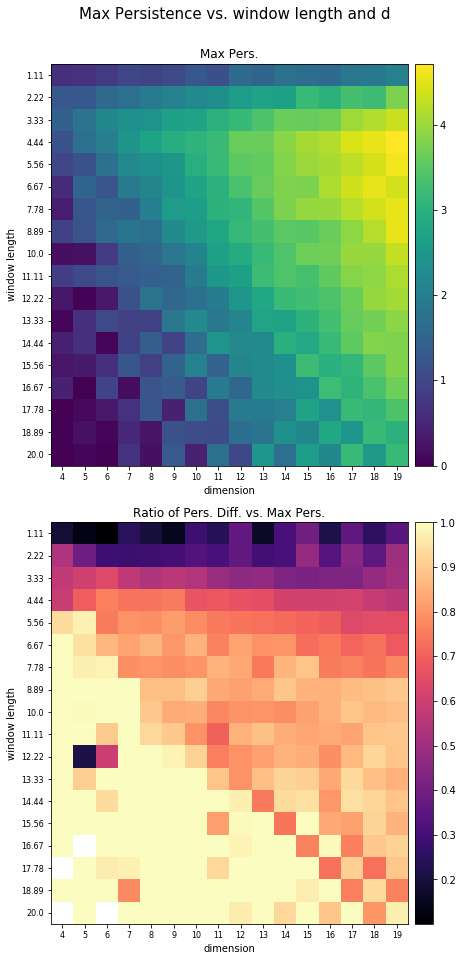

In [18]:
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.axes_grid1 import make_axes_locatable

plt.gcf().clear()
fig, axs = plt.subplots(2,1, figsize = (7,14))

ticksize = 8

im1 = axs[0].imshow(mpers_results)

axs[0].set_xlabel('dimension')
axs[0].set_xticks(np.arange(len(dim_test_values)))
axs[0].set_xticklabels(labels = list(dim_test_values),fontsize = ticksize)

axs[0].set_ylabel('window length')
axs[0].set_yticks(np.arange(len(window_length_test_values)))
axs[0].set_yticklabels(labels = list(np.around(window_length_test_values,2)),fontsize = ticksize)

axs[0].set_title('Max Pers.')

divider1 = make_axes_locatable(axs[0])
cax1 = divider1.append_axes('right', size='5%', pad=0.1)
fig.colorbar(im1,cax1,orientation = 'vertical')

### Do the other plot ###

im2 = axs[1].imshow(np.divide(top_diff_results,mpers_results),cmap = plt.cm.magma)

axs[1].set_xlabel('dimension')
axs[1].set_xticks(np.arange(len(dim_test_values)))
axs[1].set_xticklabels(labels = list(dim_test_values), fontsize = ticksize)


axs[1].set_ylabel('window length')
axs[1].set_yticks(np.arange(len(window_length_test_values)))
axs[1].set_yticklabels(labels = list(np.around(window_length_test_values,2)),fontsize = ticksize)
axs[1].set_title('Ratio of Pers. Diff. vs. Max Pers.')

divider2 = make_axes_locatable(axs[1])
cax2 = divider2.append_axes('right', size='5%', pad=0.1)
fig.colorbar(im2,cax2)

fig.tight_layout(rect=[0, 0.03, 1, 0.95])

fig.suptitle('Max Persistence vs. window length and d', fontsize = 15)
plt.savefig('CtsEx:wl{}dim{}T{}'.format(len(window_length_test_values),len(dim_test_values),T))

plt.show()

### Try to normalize by dimension? 

Goal is to identify which value of window length maximizes max pers for each value of dimension

# Random Geometric Graphs
We explore the application of the pipeline to dynamic geometric graphs. The points on the network are still sampled via a point process / queueing model.

In [4]:
importlib.reload(ctsm)
importlib.reload(sphere)

## Setup Sensor Lifetimes
T = 15 # Period 
threshold = 0.1

obsfn = lambda t, p: sphere.periodic_northsouth_modulated(t,p,T)
edge_wtsfn = lambda points: sphere.get_edge_wts_rgg(points, threshold, alpha = 1.0)

lambda1 = 50
lambda2 = lambda1

In [5]:
sensor_lifetimes = ctsm.get_sensor_lifetimes(1000,2.5*T, lambda1, lambda2)

In [21]:
## Create the Dynamic Network
### This takes WAY too long as of 8/30/2020.

### Can also parallellize this
dynamic_network_samples = 10
ts = np.linspace(0,2*T,dynamic_network_samples)

import time 

start = time.time()
(node_wts,edge_wts, allpoints) = ctsm.sample_dynamic_geometric_graph(sensor_lifetimes, ts, obsfn = obsfn);
end = time.time()
print(end - start)

# 53 seconds for 40 samples, vs 174 seconds without parallel, 8 cores

2.1151039600372314


In [22]:
## Apply the analysis
import multiprocessing as mp
from joblib import Parallel, delayed

num_cores = mp.cpu_count() - 4

# apply phi functions, and scale the weights
# phi_node_wts, phi_edge_wts = gf.weight_fn(node_wts, edge_wts, lamda=1, phi=sphere.linear_phi_fn)
## Above is not applicable anymore.

# construct the filtrations / simplicial complexes according to our construction
filtration_matrix = list(map(lambda n, e: pf.get_filtration(n, e), node_wts, edge_wts))

# summarize these filtrations using H_0 barcodes
### can paralleilize

start = time.time()
#barcodes = list(map(pf.get_rips_complex, filtration_matrix))
barcodes = Parallel(n_jobs = num_cores)(delayed(pf.get_rips_complex)(filt) for filt in filtration_matrix)
end = time.time()
print(end - start)

start = time.time()
bn_dist_matrix = pf.get_bottleneck_dist_matrix(barcodes)
end = time.time()
print(end - start)  

start = time.time()
sw_vecs_indices = sw.sliding_window(range(len(barcodes)), d=10, tau=1)
sw_dist_matrix = sw.sw_distance_matrix(sw_vecs_indices, bn_dist_matrix)
end = time.time()
print(end - start) 

# get H1 from the sliding window distance matrix
start = time.time()
PDs = ripser(sw_dist_matrix, distance_matrix=True, maxdim=1, coeff=2)['dgms']
end = time.time()
print(end - start) 

0.8134689331054688
0.0023758411407470703
0.00019407272338867188
0.0003161430358886719


In [23]:
PDs

[array([[ 0., inf]]), array([], shape=(0, 2), dtype=float64)]

### Test Connectivity of the random geometric graph

### vary params

In [3]:
## Create the dynamic network
import time 
T = 10 # Period 

obsfn = lambda t, p: sphere.periodic_northsouth_modulated(t,p,T)

lambda1 = 50
lambda2 = lambda1

sensor_lifetimes = ctsm.get_sensor_lifetimes(2000,4*T, lambda1, lambda2)


## Vary Window Length and Dimension
window_length_test_values = np.linspace(0,T,10)[5:]
dim_test_values = range(5,8)

mpers_results = np.zeros((len(window_length_test_values),len(dim_test_values)))
top_diff_results = np.zeros((len(window_length_test_values),len(dim_test_values)))
PD_results = {}

for i,wl in enumerate(window_length_test_values):
    for j,d in enumerate(dim_test_values):
        print(wl/T,d)

        # resample dynamic network; this isn't really done correctly?
        tau = wl/d
        ts = np.arange(0,T,tau) 
        
        start = time.time()
        (node_wts,edge_wts, allpoints) = ctsm.sample_dynamic_geometric_graph(sensor_lifetimes, ts, obsfn = obsfn)
        end = time.time()
        print("Creating dynamic network", end - start) 
        
        start = time.time()
        # tau is 1 below to ensure
        PDs = sphere.apply_pipeline(node_wts,edge_wts, d = d, tau = 1, lamda=1, phi=sphere.identity_phi_fn) # get the PDs
        PD_results[i,j] = PDs[1]
        res = (sphere.get_maximum_persistence(PDs)[1],sphere.get_top_diff_persistence(PDs)[1], sphere.get_num_features(PDs)[1])
        end = time.time()
        print("Time to analyze sliding window point cloud", end - start) 

        mpers_results[i,j] = res[0]
        top_diff_results[i,j] = res[1]

0.5555555555555556 5
Creating dynamic network 6.646997928619385
Time to analyze sliding window point cloud 2.4740538597106934
0.5555555555555556 6
Creating dynamic network 5.312673091888428
Time to analyze sliding window point cloud 3.1614949703216553
0.5555555555555556 7
Creating dynamic network 6.247070074081421


/Users/timothysudijono/anaconda3/envs/mypython3/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:703: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Time to analyze sliding window point cloud 3.9146008491516113
0.6666666666666667 5
Creating dynamic network 4.499077796936035
Time to analyze sliding window point cloud 2.0595011711120605
0.6666666666666667 6
Creating dynamic network 5.469985008239746
Time to analyze sliding window point cloud 3.259826898574829
0.6666666666666667 7
Creating dynamic network 5.648011922836304
Time to analyze sliding window point cloud 3.2257909774780273
0.7777777777777779 5
Creating dynamic network 3.8578569889068604
Time to analyze sliding window point cloud 2.9992780685424805
0.7777777777777779 6
Creating dynamic network 4.891623020172119
Time to analyze sliding window point cloud 2.927725076675415
0.7777777777777779 7
Creating dynamic network 4.796242952346802
Time to analyze sliding window point cloud 2.3252499103546143
0.888888888888889 5
Creating dynamic network 3.43139386177063
Time to analyze sliding window point cloud 2.4558868408203125
0.888888888888889 6
Creating dynamic network 4.032828807830

### more efficient way to vary params?

In [2]:
## Create the dynamic network
import time 
import multiprocessing as mp
from importlib import reload
reload(ctsm)
T = 10 # Period 

#obsfn = lambda t, p: sphere.periodic_northsouth_modulated(t,p,T)

obsfn = lambda t, p: sphere

lambda1 = 50
lambda2 = lambda1

In [3]:
len(np.arange(0,2*T,0.1))

200

In [4]:
## 
start = time.time()
sensor_lifetimes = ctsm.get_sensor_lifetimes(300,4*T, lambda1, lambda2)
end = time.time()
print("Sampling sensor birth times and death times", end - start) 

Sampling sensor birth times and death times 0.7492201328277588


In [5]:
## 200 samples in 10 seconds
## 400 samples in 15 seconds
## 2000 samples in 92 seconds
## 4000 samples in 205 seconds
step_size = 0.1
ts = np.arange(0,2*T,step_size) 
start = time.time()
(node_wts,edge_wts, allpoints) = ctsm.sample_dynamic_geometric_graph(sensor_lifetimes, ts,
                                                                     obsfn = obsfn,
                                                                    rescale_node_weight=1)
end = time.time()
print("Creating dynamic network", end - start) 

Creating dynamic network 6.960092306137085


In [6]:
import multiprocessing as mp
from joblib import Parallel, delayed

start = time.time()
filtration_matrix = list(map(lambda n, e: pf.get_filtration(n, e), node_wts, edge_wts))
end = time.time()
print("Converting to filtration matrices", end - start) 


Converting to filtration matrices 0.35579490661621094


In [7]:
len(ts)

200

In [8]:
start = time.time()
num_cores = mp.cpu_count() - 4
barcodes = Parallel(n_jobs = num_cores)(delayed(pf.get_rips_complex)(filt) for filt in filtration_matrix)
end = time.time()
print("Computing barcodes", end - start) 

Computing barcodes 1.0049340724945068


In [9]:
start = time.time()
bn_dist_matrix = pf.get_bottleneck_dist_matrix(barcodes)
end = time.time()
print("Computing bottleneck", end - start) 

Computing bottleneck 0.8078060150146484


## Details

Need to think about how to normalize the sliding window point cloud to achieve similar comparison of the point clouds.

There seem to be two options here. One is to just normalize the function values before they are fed into the computation of the sublevel set filtration.

The other is to scale the metric space to be comparable perhaps by just having the same diameters. When do we do this step. Currently it is scaling the sliding window point cloud (as a metric space), but does this work?



Why don't we need to normalize the example with sine curve? 

In [18]:
## Vary Window Length and Dimension
window_length_test_values = np.linspace(0,2*T,20)[1:]
dim_test_values = range(3,10)

mpers_results = np.zeros((len(window_length_test_values),len(dim_test_values)))
top_diff_results = np.zeros((len(window_length_test_values),len(dim_test_values)))
PD_results = {}

for i,wl in enumerate(window_length_test_values):
    for j,d in enumerate(dim_test_values):
        print(wl/T,d)
        
        tau = wl/d
    
        # construct a sliding window embedding
        sw_vecs_indices = sw.sliding_window(range(len(barcodes)), d=d, tau= int(wl/(d*step_size)) )
        sw_dist_matrix = sw.sw_distance_matrix(sw_vecs_indices, bn_dist_matrix, rescale = 1)
        PDs = ripser(sw_dist_matrix, distance_matrix=True, maxdim=1, coeff=2)['dgms']
        
        # tau is 1 below to ensure
        PD_results[i,j] = PDs[1]
        res = (sphere.get_maximum_persistence(PDs)[1],
               sphere.get_top_diff_persistence(PDs)[1],
               sphere.get_num_features(PDs)[1])
        

        mpers_results[i,j] = res[0]
        top_diff_results[i,j] = res[1]

0.10526315789473684 3
0.10526315789473684 4
0.10526315789473684 5
0.10526315789473684 6
0.10526315789473684 7
0.10526315789473684 8
0.10526315789473684 9
0.21052631578947367 3
0.21052631578947367 4
0.21052631578947367 5
0.21052631578947367 6
0.21052631578947367 7
0.21052631578947367 8
0.21052631578947367 9
0.3157894736842105 3
0.3157894736842105 4
0.3157894736842105 5
0.3157894736842105 6
0.3157894736842105 7
0.3157894736842105 8
0.3157894736842105 9
0.42105263157894735 3
0.42105263157894735 4
0.42105263157894735 5
0.42105263157894735 6
0.42105263157894735 7
0.42105263157894735 8
0.42105263157894735 9
0.5263157894736842 3
0.5263157894736842 4
0.5263157894736842 5
0.5263157894736842 6
0.5263157894736842 7
0.5263157894736842 8
0.5263157894736842 9
0.631578947368421 3
0.631578947368421 4
0.631578947368421 5
0.631578947368421 6
0.631578947368421 7
0.631578947368421 8
0.631578947368421 9
0.7368421052631579 3
0.7368421052631579 4
0.7368421052631579 5
0.7368421052631579 6
0.7368421052631579 7

<ipython-input-19-f659a2d4e868>:27: RuntimeWarning: invalid value encountered in true_divide
  im2 = axs[1].imshow(np.divide(top_diff_results,mpers_results),cmap = plt.cm.magma)


<Figure size 432x288 with 0 Axes>

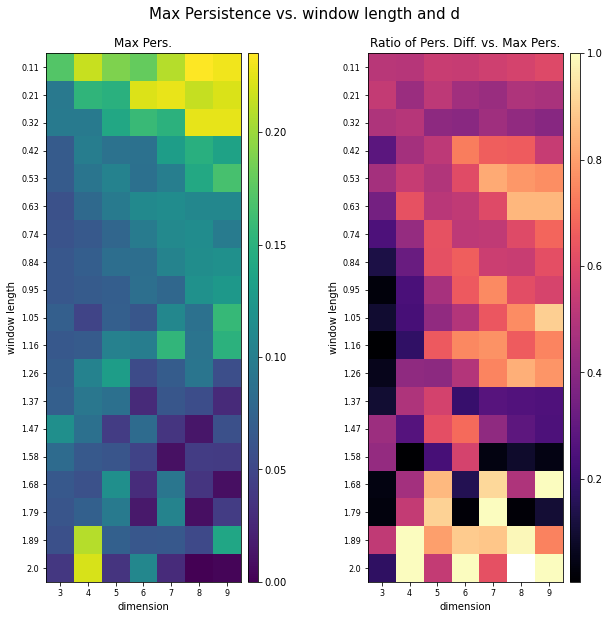

In [19]:
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.axes_grid1 import make_axes_locatable

plt.gcf().clear()
fig, axs = plt.subplots(1,2,figsize = (9,9))

ticksize = 8

im1 = axs[0].imshow(mpers_results)

axs[0].set_xlabel('dimension')
axs[0].set_xticks(np.arange(len(dim_test_values)))
axs[0].set_xticklabels(labels = list(dim_test_values),fontsize = ticksize)

axs[0].set_ylabel('window length')
axs[0].set_yticks(np.arange(len(window_length_test_values)))
axs[0].set_yticklabels(labels = list(np.around(window_length_test_values/T,2)),fontsize = ticksize)

axs[0].set_title('Max Pers.')

divider1 = make_axes_locatable(axs[0])
cax1 = divider1.append_axes('right', size='5%', pad=0.1)
fig.colorbar(im1,cax1,orientation = 'vertical')

### Do the other plot ###

im2 = axs[1].imshow(np.divide(top_diff_results,mpers_results),cmap = plt.cm.magma)

axs[1].set_xlabel('dimension')
axs[1].set_xticks(np.arange(len(dim_test_values)))
axs[1].set_xticklabels(labels = list(dim_test_values), fontsize = ticksize)


axs[1].set_ylabel('window length')
axs[1].set_yticks(np.arange(len(window_length_test_values)))
axs[1].set_yticklabels(labels = list(np.around(window_length_test_values/T,2)),fontsize = ticksize)
axs[1].set_title('Ratio of Pers. Diff. vs. Max Pers.')

divider2 = make_axes_locatable(axs[1])
cax2 = divider2.append_axes('right', size='5%', pad=0.1)
fig.colorbar(im2,cax2)

fig.tight_layout(rect=[0, 0.03, 1, 0.95])

fig.suptitle('Max Persistence vs. window length and d', fontsize = 15)
plt.savefig('CtsEx:wl{}dim{}T{}'.format(len(window_length_test_values),len(dim_test_values),T))

plt.show()

### What experiments to run?

- number of points, 
- how fast the number of samples changes
- increased samples time period
- MDS analysis


In [14]:
wl = 0.5*T
d = 4
sw_vecs_indices = sw.sliding_window(range(len(barcodes)), d=d, tau= int(wl/(d*0.01)) )
sw_dist_matrix = sw.sw_distance_matrix(sw_vecs_indices, bn_dist_matrix)
print(sw_dist_matrix.shape)

from sklearn.manifold import MDS
embedding = MDS(n_components=3, dissimilarity='precomputed')
X_transformed = embedding.fit_transform(sw_dist_matrix)
print(X_transformed.shape)

(1, 1)


/Users/timothysudijono/anaconda3/envs/mypython3/lib/python3.8/site-packages/sklearn/manifold/_mds.py:128: RuntimeWarning: invalid value encountered in double_scalars
  old_stress = stress / dis
/Users/timothysudijono/anaconda3/envs/mypython3/lib/python3.8/site-packages/sklearn/manifold/_mds.py:123: RuntimeWarning: invalid value encountered in double_scalars
  if(old_stress - stress / dis) < eps:
/Users/timothysudijono/anaconda3/envs/mypython3/lib/python3.8/site-packages/sklearn/manifold/_mds.py:128: RuntimeWarning: invalid value encountered in double_scalars
  old_stress = stress / dis
/Users/timothysudijono/anaconda3/envs/mypython3/lib/python3.8/site-packages/sklearn/manifold/_mds.py:123: RuntimeWarning: invalid value encountered in double_scalars
  if(old_stress - stress / dis) < eps:
/Users/timothysudijono/anaconda3/envs/mypython3/lib/python3.8/site-packages/sklearn/manifold/_mds.py:128: RuntimeWarning: invalid value encountered in double_scalars
  old_stress = stress / dis
/Users/t

(1, 3)


/Users/timothysudijono/anaconda3/envs/mypython3/lib/python3.8/site-packages/sklearn/manifold/_mds.py:128: RuntimeWarning: invalid value encountered in double_scalars
  old_stress = stress / dis
/Users/timothysudijono/anaconda3/envs/mypython3/lib/python3.8/site-packages/sklearn/manifold/_mds.py:123: RuntimeWarning: invalid value encountered in double_scalars
  if(old_stress - stress / dis) < eps:
/Users/timothysudijono/anaconda3/envs/mypython3/lib/python3.8/site-packages/sklearn/manifold/_mds.py:128: RuntimeWarning: invalid value encountered in double_scalars
  old_stress = stress / dis
/Users/timothysudijono/anaconda3/envs/mypython3/lib/python3.8/site-packages/sklearn/manifold/_mds.py:123: RuntimeWarning: invalid value encountered in double_scalars
  if(old_stress - stress / dis) < eps:
/Users/timothysudijono/anaconda3/envs/mypython3/lib/python3.8/site-packages/sklearn/manifold/_mds.py:128: RuntimeWarning: invalid value encountered in double_scalars
  old_stress = stress / dis
/Users/t

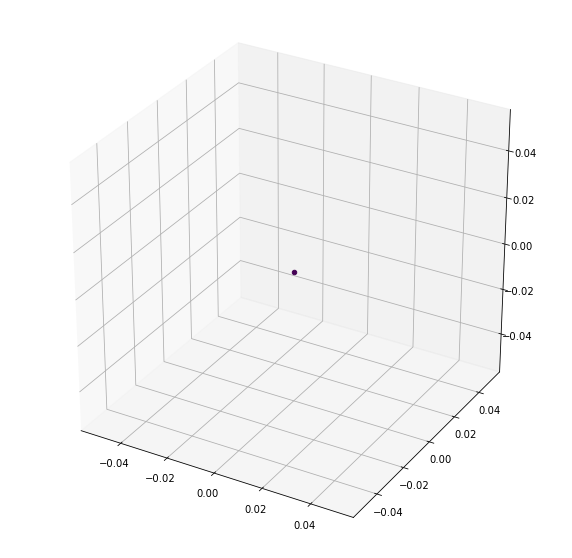

In [15]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_transformed[:,0],X_transformed[:,1],X_transformed[:,2],
           c = np.linspace(0,1,X_transformed.shape[0]),
           cmap = plt.cm.viridis)